In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:

xy = pd.read_parquet('XY_version1.parquet')
xy.head()

,year,area,avg_yield_maize_corn_1y,avg_yield_maize_corn_3y,avg_yield_maize_corn_6y,avg_yield_other_vegetables_fresh_nec_1y,avg_yield_other_vegetables_fresh_nec_3y,avg_yield_other_vegetables_fresh_nec_6y,avg_yield_potatoes_1y,avg_yield_potatoes_3y,...,Y_oil_palm_fruit,Y_other_vegetables_fresh_nec,Y_potatoes,Y_rice,Y_soya_beans,Y_sugar_beet,Y_sugar_cane,Y_tomatoes,Y_watermelons,Y_wheat
0,1983,Afghanistan,1665.8,1668.633333,1636.283333,6919.2,6846.166667,6561.216667,15511.4,15265.133333,...,NaN,7065.7,15764.7,2258.1,NaN,20000.0,19375.0,NaN,9754.9,1258.0
1,1984,Afghanistan,1664.1,1666.300000,1649.750000,7065.7,6959.033333,6775.366667,15764.7,15566.600000,...,NaN,7155.1,14444.4,2241.6,NaN,20000.0,19354.8,NaN,9630.0,1231.9
2,1985,Afghanistan,1661.2,1663.700000,1656.900000,7155.1,7046.666667,6897.800000,14444.4,15240.166667,...,NaN,7145.9,14090.9,2248.2,NaN,3333.3,19333.3,NaN,9556.7,1227.7
3,1986,Afghanistan,1665.2,1663.500000,1666.066667,7145.9,7122.233333,6984.200000,14090.9,14766.666667,...,NaN,7249.5,15866.7,2240.0,NaN,12500.0,20000.0,NaN,10058.8,1189.0
4,1987,Afghanistan,1687.5,1671.300000,1668.800000,7249.5,7183.500000,7071.266667,15866.7,14800.666667,...,NaN,7524.8,15500.0,2000.0,NaN,15000.0,20000.0,NaN,9952.9,1284.9


In [3]:
latlong  = pd.read_csv('coordinates_countries_full_209.csv')
latlong['area'] = latlong['Area'].str.replace(' ', '_')
latlong = latlong[['area', 'latitude', 'longitude']]

In [4]:
xy = xy.merge(latlong, on='area')
xy = pd.get_dummies(xy, columns=['area'])
xy.columns = (
    xy.columns
    .str.strip()             # remove leading/trailing spaces
    .str.replace(' ', '_')   # replace spaces
    .str.replace(r'[^A-Za-z0-9_]', '', regex=True)  # remove special chars
)
xy.columns.tolist()

['year',
 'avg_yield_maize_corn_1y',
 'avg_yield_maize_corn_3y',
 'avg_yield_maize_corn_6y',
 'avg_yield_other_vegetables_fresh_nec_1y',
 'avg_yield_other_vegetables_fresh_nec_3y',
 'avg_yield_other_vegetables_fresh_nec_6y',
 'avg_yield_potatoes_1y',
 'avg_yield_potatoes_3y',
 'avg_yield_potatoes_6y',
 'avg_yield_rice_1y',
 'avg_yield_rice_3y',
 'avg_yield_rice_6y',
 'avg_yield_sugar_cane_1y',
 'avg_yield_sugar_cane_3y',
 'avg_yield_sugar_cane_6y',
 'avg_yield_wheat_1y',
 'avg_yield_wheat_3y',
 'avg_yield_wheat_6y',
 'avg_yield_oil_palm_fruit_1y',
 'avg_yield_oil_palm_fruit_3y',
 'avg_yield_oil_palm_fruit_6y',
 'avg_yield_barley_1y',
 'avg_yield_barley_3y',
 'avg_yield_barley_6y',
 'avg_yield_soya_beans_1y',
 'avg_yield_soya_beans_3y',
 'avg_yield_soya_beans_6y',
 'avg_yield_sugar_beet_1y',
 'avg_yield_sugar_beet_3y',
 'avg_yield_sugar_beet_6y',
 'avg_yield_watermelons_1y',
 'avg_yield_watermelons_3y',
 'avg_yield_watermelons_6y',
 'avg_yield_cucumbers_and_gherkins_1y',
 'avg_yield_cuc

In [5]:
features_col =[
 'avg_yield_maize_corn_1y',
 'avg_yield_maize_corn_3y',
 'avg_yield_maize_corn_6y',
 'avg_yield_other_vegetables_fresh_nec_1y',
 'avg_yield_other_vegetables_fresh_nec_3y',
 'avg_yield_other_vegetables_fresh_nec_6y',
 'avg_yield_potatoes_1y',
 'avg_yield_potatoes_3y',
 'avg_yield_potatoes_6y',
 'avg_yield_rice_1y',
 'avg_yield_rice_3y',
 'avg_yield_rice_6y',
 'avg_yield_sugar_cane_1y',
 'avg_yield_sugar_cane_3y',
 'avg_yield_sugar_cane_6y',
 'avg_yield_wheat_1y',
 'avg_yield_wheat_3y',
 'avg_yield_wheat_6y',
 'avg_yield_oil_palm_fruit_1y',
 'avg_yield_oil_palm_fruit_3y',
 'avg_yield_oil_palm_fruit_6y',
 'avg_yield_barley_1y',
 'avg_yield_barley_3y',
 'avg_yield_barley_6y',
 'avg_yield_soya_beans_1y',
 'avg_yield_soya_beans_3y',
 'avg_yield_soya_beans_6y',
 'avg_yield_sugar_beet_1y',
 'avg_yield_sugar_beet_3y',
 'avg_yield_sugar_beet_6y',
 'avg_yield_watermelons_1y',
 'avg_yield_watermelons_3y',
 'avg_yield_watermelons_6y',
 'avg_yield_cucumbers_and_gherkins_1y',
 'avg_yield_cucumbers_and_gherkins_3y',
 'avg_yield_cucumbers_and_gherkins_6y',
 'avg_yield_tomatoes_1y',
 'avg_yield_tomatoes_3y',
 'avg_yield_tomatoes_6y',
 'avg_yield_bananas_1y',
 'avg_yield_bananas_3y',
 'avg_yield_bananas_6y',
 'avg_yield_cassava_fresh_1y',
 'avg_yield_cassava_fresh_3y',
 'avg_yield_cassava_fresh_6y',
 'rain_Jan',
 'rain_Feb',
 'rain_Mar',
 'rain_Apr',
 'rain_May',
 'rain_Jun',
 'rain_Jul',
 'rain_Aug',
 'rain_Sep',
 'rain_Oct',
 'rain_Nov',
 'rain_Dec',
 'avg_rain_1_3',
 'avg_rain_3_6',
 'avg_rain_6_9',
 'avg_rain_10_12',
 'avg_rain_1_12',
 'solar_Jan',
 'solar_Feb',
 'solar_Mar',
 'solar_Apr',
 'solar_May',
 'solar_Jun',
 'solar_Jul',
 'solar_Aug',
 'solar_Sep',
 'solar_Oct',
 'solar_Nov',
 'solar_Dec',
 'avg_solar_1_3',
 'avg_solar_3_6',
 'avg_solar_6_9',
 'avg_solar_10_12',
 'avg_solar_1_12',
 'temp_Jan',
 'temp_Feb',
 'temp_Mar',
 'temp_Apr',
 'temp_May',
 'temp_Jun',
 'temp_Jul',
 'temp_Aug',
 'temp_Sep',
 'temp_Oct',
 'temp_Nov',
 'temp_Dec',
 'avg_temp_1_3',
 'avg_temp_3_6',
 'avg_temp_6_9',
 'avg_temp_10_12',
 'avg_temp_1_12',
 'sum_rain_1_3',
 'sum_rain_3_6',
 'sum_rain_6_9',
 'sum_rain_10_12',
 'sum_rain_1_12',

 'latitude',
 'longitude',
 'area_Afghanistan',
 'area_Albania',
 'area_Algeria',
 'area_Angola',
 'area_Antigua_and_Barbuda',
 'area_Argentina',
 'area_Armenia',
 'area_Australia',
 'area_Austria',
 'area_Azerbaijan',
 'area_Bahamas',
 'area_Bangladesh',
 'area_Barbados',
 'area_Belarus',
 'area_Belgium',
 'area_BelgiumLuxembourg',
 'area_Belize',
 'area_Benin',
 'area_Bhutan',
 'area_Bolivia_Plurinational_State_of',
 'area_Bosnia_and_Herzegovina',
 'area_Botswana',
 'area_Brazil',
 'area_Bulgaria',
 'area_Burkina_Faso',
 'area_Burundi',
 'area_Cabo_Verde',
 'area_Cambodia',
 'area_Cameroon',
 'area_Canada',
 'area_Central_African_Republic',
 'area_Chad',
 'area_Chile',
 'area_China',
 'area_China_Taiwan_Province_of',
 'area_China_mainland',
 'area_Colombia',
 'area_Comoros',
 'area_Congo',
 'area_Costa_Rica',
 'area_Croatia',
 'area_Cuba',
 'area_Czechia',
 'area_Czechoslovakia',
 'area_Cte_dIvoire',
 'area_Democratic_Peoples_Republic_of_Korea',
 'area_Democratic_Republic_of_the_Congo',
 'area_Denmark',
 'area_Djibouti',
 'area_Dominica',
 'area_Dominican_Republic',
 'area_Ecuador',
 'area_Egypt',
 'area_El_Salvador',
 'area_Eritrea',
 'area_Eswatini',
 'area_Ethiopia',
 'area_Ethiopia_PDR',
 'area_Fiji',
 'area_France',
 'area_French_Guiana',
 'area_Gabon',
 'area_Gambia',
 'area_Georgia',
 'area_Germany',
 'area_Ghana',
 'area_Greece',
 'area_Grenada',
 'area_Guatemala',
 'area_Guinea',
 'area_GuineaBissau',
 'area_Guyana',
 'area_Haiti',
 'area_Honduras',
 'area_Hungary',
 'area_India',
 'area_Indonesia',
 'area_Iran_Islamic_Republic_of',
 'area_Iraq',
 'area_Israel',
 'area_Italy',
 'area_Jamaica',
 'area_Japan',
 'area_Jordan',
 'area_Kazakhstan',
 'area_Kenya',
 'area_Kuwait',
 'area_Kyrgyzstan',
 'area_Lao_Peoples_Democratic_Republic',
 'area_Lebanon',
 'area_Lesotho',
 'area_Libya',
 'area_Lithuania',
 'area_Luxembourg',
 'area_Madagascar',
 'area_Malawi',
 'area_Malaysia',
 'area_Maldives',
 'area_Mali',
 'area_Mauritania',
 'area_Mauritius',
 'area_Mexico',
 'area_Micronesia_Federated_States_of',
 'area_Montenegro',
 'area_Morocco',
 'area_Mozambique',
 'area_Myanmar',
 'area_Namibia',
 'area_Nepal',
 'area_Netherlands_Kingdom_of_the',
 'area_New_Caledonia',
 'area_New_Zealand',
 'area_Nicaragua',
 'area_Niger',
 'area_Nigeria',
 'area_North_Macedonia',
 'area_Oman',
 'area_Pakistan',
 'area_Panama',
 'area_Papua_New_Guinea',
 'area_Paraguay',
 'area_Peru',
 'area_Philippines',
 'area_Poland',
 'area_Portugal',
 'area_Puerto_Rico',
 'area_Qatar',
 'area_Republic_of_Korea',
 'area_Republic_of_Moldova',
 'area_Romania',
 'area_Russian_Federation',
 'area_Rwanda',
 'area_Runion',
 'area_Saint_Vincent_and_the_Grenadines',
 'area_Sao_Tome_and_Principe',
 'area_Saudi_Arabia',
 'area_Senegal',
 'area_Serbia',
 'area_Serbia_and_Montenegro',
 'area_Sierra_Leone',
 'area_Slovakia',
 'area_Slovenia',
 'area_Somalia',
 'area_South_Africa',
 'area_South_Sudan',
 'area_Spain',
 'area_Sri_Lanka',
 'area_Sudan',
 'area_Sudan_former',
 'area_Suriname',
 'area_Sweden',
 'area_Switzerland',
 'area_Syrian_Arab_Republic',
 'area_Tajikistan',
 'area_Thailand',
 'area_TimorLeste',
 'area_Togo',
 'area_Trinidad_and_Tobago',
 'area_Turkmenistan',
 'area_Trkiye',
 'area_USSR',
 'area_Uganda',
 'area_Ukraine',
 'area_United_Arab_Emirates',
 'area_United_Republic_of_Tanzania',
 'area_United_States_of_America',
 'area_Uruguay',
 'area_Uzbekistan',
 'area_Vanuatu',
 'area_Venezuela_Bolivarian_Republic_of',
 'area_Viet_Nam',
 'area_Yemen',
 'area_Yugoslav_SFR',
 'area_Zambia',
 'area_Zimbabwe']




Start LSTM Model

Rows -> train: 116 val: 25 test: 25


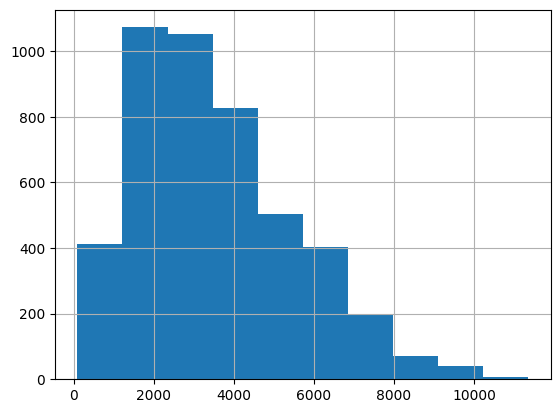

In [6]:
xy_drop_na = xy[xy['Y_rice']>=0]
xy['Y_rice'].hist()
xy_drop_na = xy[xy["Y_rice"] >= 0].copy()

# Remove inf and NaN in all columns
xy_drop_na = xy_drop_na.replace([np.inf, -np.inf], np.nan).dropna()

# Time-based split
test_xy  = xy_drop_na[xy_drop_na["year"] >= 2019].copy()
train_val_xy = xy_drop_na[xy_drop_na["year"] < 2019].copy()

train_xy = train_val_xy[train_val_xy["year"] < 2014].copy()
val_xy   = train_val_xy[train_val_xy["year"] >= 2014].copy()

print("Rows -> train:", len(train_xy), "val:", len(val_xy), "test:", len(test_xy))


Using device: cpu
Number of features: 293
X_train_scaled NaN: False inf: False shape: (116, 293)
y_train NaN: False inf: False shape: (116,)
X_val_scaled NaN: False inf: False shape: (25, 293)
y_val NaN: False inf: False shape: (25,)
X_test_scaled NaN: False inf: False shape: (25, 293)
y_test NaN: False inf: False shape: (25,)
Created sequences: 101 samples, seq_len=3, num_features=293
Created sequences: 10 samples, seq_len=3, num_features=293
Created sequences: 10 samples, seq_len=3, num_features=293
YieldLSTM(
  (lstm): LSTM(293, 64, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)
Epoch 1/150 - Train MSE: 26672855.0000, Val MSE: 33653020.0000
Epoch 2/150 - Train MSE: 26533301.0000, Val MSE: 33325370.0000
Epoch 3/150 - Train MSE: 26203784.0000, Val MSE: 32764320.0000
Epoch 4/150 - Train MSE: 25655316.0000, Val MSE: 31936612.0000


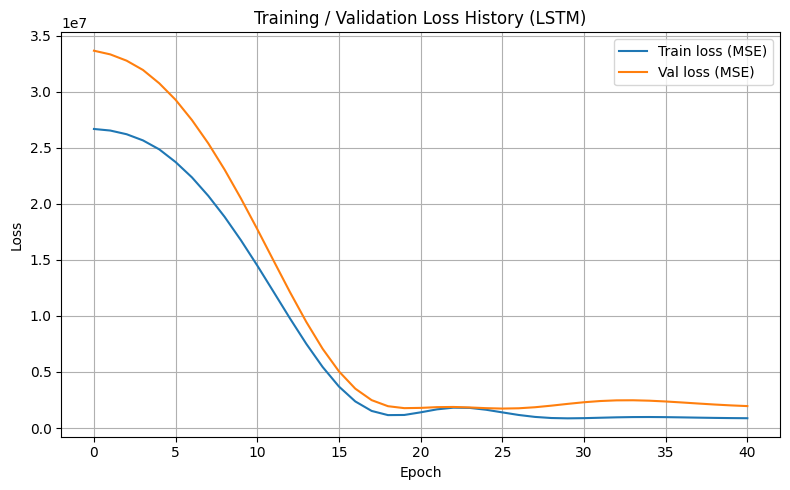

TypeError: got an unexpected keyword argument 'squared'

In [7]:
# ================================
# 0. Imports & device
# ================================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =====================================================
# 1. Feature / target definition & scaling (tabular)
# =====================================================

target_col = "Y_rice"
non_feature_cols = ["Y_rice"]  # keep year + all area_ one-hot columns

feature_cols = [c for c in xy.columns if c not in non_feature_cols]
print("Number of features:", len(feature_cols))

# Build feature/target DataFrames for each split
X_train_df = train_xy[feature_cols].copy()
y_train_df = train_xy[[target_col]].copy()

X_val_df   = val_xy[feature_cols].copy()
y_val_df   = val_xy[[target_col]].copy()

X_test_df  = test_xy[feature_cols].copy()
y_test_df  = test_xy[[target_col]].copy()

# ---- Scale features with StandardScaler (fit on train only) ----
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_df).astype(np.float32)
X_val_scaled   = scaler_X.transform(X_val_df).astype(np.float32)
X_test_scaled  = scaler_X.transform(X_test_df).astype(np.float32)

# Targets in original scale (we'll use RMSE later)
y_train = y_train_df[target_col].to_numpy().astype(np.float32)
y_val   = y_val_df[target_col].to_numpy().astype(np.float32)
y_test  = y_test_df[target_col].to_numpy().astype(np.float32)

# Sanity checks
def check_arr(name, arr):
    print(name, "NaN:", np.isnan(arr).any(), "inf:", np.isinf(arr).any(), "shape:", arr.shape)

check_arr("X_train_scaled", X_train_scaled)
check_arr("y_train", y_train)
check_arr("X_val_scaled",   X_val_scaled)
check_arr("y_val",          y_val)
check_arr("X_test_scaled",  X_test_scaled)
check_arr("y_test",         y_test)

# =====================================================
# 2. Sequence construction for LSTM
#    - group by area_* (one-hot), then sort by year
#    - create sliding windows of length seq_len
#      to predict next year's Y_rice
# =====================================================

def create_sequences(df_raw, X_scaled, y_raw, feature_cols, target_col, seq_len):
    """
    df_raw: original pandas DataFrame split (train_xy, val_xy, test_xy)
    X_scaled: numpy array of scaled features, same row order as df_raw
    y_raw: numpy array of target (Y_rice), same row order as df_raw
    Returns: X_seq (N, seq_len, num_features), y_seq (N,)
    """
    df = df_raw.copy().reset_index(drop=True)
    X = X_scaled
    y = y_raw

    # Determine area key from one-hot columns
    area_cols = [c for c in df.columns if c.startswith("area_")]
    if len(area_cols) == 0:
        # fallback: treat whole dataset as single group
        df["area_key"] = "ALL"
    else:
        df["area_key"] = df[area_cols].idxmax(axis=1)

    # Attach indices so we can map back to X_scaled / y
    df["row_idx"] = np.arange(len(df))

    X_seqs = []
    y_seqs = []

    # Group by area and sort by year
    for area, g in df.groupby("area_key"):
        g = g.sort_values("year")
        idxs = g["row_idx"].to_numpy()

        if len(idxs) <= seq_len:
            continue  # not enough points for a sequence

        # Sliding windows
        for i in range(len(idxs) - seq_len):
            seq_idx = idxs[i:i+seq_len]
            target_idx = idxs[i+seq_len]

            X_seqs.append(X[seq_idx, :])
            y_seqs.append(y[target_idx])

    X_seqs = np.array(X_seqs, dtype=np.float32)
    y_seqs = np.array(y_seqs, dtype=np.float32)

    print(f"Created sequences: {X_seqs.shape[0]} samples, "
          f"seq_len={seq_len}, num_features={X_seqs.shape[2] if X_seqs.size>0 else 'NA'}")

    return X_seqs, y_seqs

# Hyperparameter: sequence length
seq_len = 3  # years

X_train_seq, y_train_seq = create_sequences(train_xy, X_train_scaled, y_train,
                                            feature_cols, target_col, seq_len)
X_val_seq,   y_val_seq   = create_sequences(val_xy,   X_val_scaled,   y_val,
                                            feature_cols, target_col, seq_len)
X_test_seq,  y_test_seq  = create_sequences(test_xy,  X_test_scaled,  y_test,
                                            feature_cols, target_col, seq_len)

# =====================================================
# 3. PyTorch Dataset and DataLoader for sequences
# =====================================================

batch_size = 64

train_dataset = TensorDataset(
    torch.from_numpy(X_train_seq),
    torch.from_numpy(y_train_seq).unsqueeze(-1)  # (N,1)
)
val_dataset = TensorDataset(
    torch.from_numpy(X_val_seq),
    torch.from_numpy(y_val_seq).unsqueeze(-1)
)
test_dataset = TensorDataset(
    torch.from_numpy(X_test_seq),
    torch.from_numpy(y_test_seq).unsqueeze(-1)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# =====================================================
# 4. LSTM model definition
# =====================================================

class YieldLSTM(nn.Module):
    def __init__(self, num_features, hidden_size=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        # x: (batch, seq_len, num_features)
        out, (hn, cn) = self.lstm(x)   # hn: (num_layers, batch, hidden_size)
        last_hidden = hn[-1]           # (batch, hidden_size)
        out = self.fc(last_hidden)     # (batch, 1)
        return out

num_features = X_train_seq.shape[2]
hidden_size  = 64
num_layers   = 2
dropout      = 0.1
learning_rate = 0.1
num_epochs    = 150
patience      = 15

model = YieldLSTM(num_features, hidden_size, num_layers, dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

# =====================================================
# 5. Training loop with early stopping
# =====================================================

def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=100, patience=10, device="cpu"):
    best_state_dict = model.state_dict()
    best_val_loss = float("inf")
    patience_counter = 0

    train_losses = []
    val_losses   = []

    for epoch in range(num_epochs):
        # ---- Train ----
        model.train()
        running_train_loss = 0.0

        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        train_loss = running_train_loss / max(1, len(train_loader))

        # ---- Validate ----
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                running_val_loss += loss.item()

        val_loss = running_val_loss / max(1, len(val_loader))

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"- Train MSE: {train_loss:.4f}, Val MSE: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best weights
    model.load_state_dict(best_state_dict)
    return model, train_losses, val_losses

model, train_losses, val_losses = train_model(
    model, train_loader, val_loader,
    criterion, optimizer,
    num_epochs=num_epochs,
    patience=patience,
    device=device
)

# =====================================================
# 6. Plot training / validation loss history (MSE)
# =====================================================

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train loss (MSE)")
plt.plot(val_losses,   label="Val loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation Loss History (LSTM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================================
# 7. Evaluation: RMSE & R² for train, val, test
# =====================================================

def predict_loader(model, data_loader, device="cpu"):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X).cpu().numpy().flatten()
            preds.extend(outputs)
            trues.extend(batch_y.numpy().flatten())
    return np.array(trues), np.array(preds)

y_train_true, y_train_pred = predict_loader(model, train_loader, device)
y_val_true,   y_val_pred   = predict_loader(model, val_loader, device)
y_test_true,  y_test_pred  = predict_loader(model, test_loader, device)

def print_metrics(name, y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    print(f"{name} -> RMSE: {rmse:.4f}, R²: {r2:.4f}")

print_metrics("Train", y_train_true, y_train_pred)
print_metrics("Val",   y_val_true,   y_val_pred)
print_metrics("Test",  y_test_true,  y_test_pred)

# =====================================================
# 8. Scatter plots: prediction vs truth for Val and Test
# =====================================================

def plot_scatter(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
    plt.xlabel("True Y_rice")
    plt.ylabel("Predicted Y_rice")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_scatter(y_val_true,  y_val_pred,  "Validation: True vs Predicted Y_rice (LSTM)")
plot_scatter(y_test_true, y_test_pred, "Test: True vs Predicted Y_rice (LSTM)")
